# Bio-JEPA AC 

Based on [V-JEPA 2 AC](https://arxiv.org/abs/2506.09985)

**Goal**
Our goal is to build a World Model for cell biology. In it's current configuration, our model calculates an latent space representation of the gene expression and network impact to a cell given a specific gene knockout, or drug if we had it in the dataset. Unlike an LLM, this is a predictive simulation that operates entirely within a compressed mathematical space to understand cause and effect.

The process begins with the inputs, which feed the model three distinct pieces of information for every training step. 
	First, it receives the **Before** state, which is data representing a healthy control cell. Based on the dataset, the model can learn across the top 4096 expressed genes. Additionally, the model has access to a set of gene to pathway mappings based on the [Drug Signatures Database (DSigDB)](https://academic.oup.com/bioinformatics/article/31/18/3069/241009) dataset. This essentially lets the model learn from gene expression and a small cheat sheet on the networks so that the model can learn what cell looks like to have high energy, low stress, and normal growth (or whatever the control state is).  This state is predicted/learned by the **Student** model.  
	Second, the model receives the **Action**, which is the specific perturbation performed in the lab, in our case a CRISPR knockdown of a specific gene. This could also be a drug application or protein introduction if we had the data. This is converted into a learnable "Action Embedding," effectively serving as the command that tells the simulation what event just occurred. This adjustment is learned by the **Action-Conditioned Predictor** model. 
	Third, the model is given the **After** state, which is the actual knockdown cell observed in the experiment. This third input serves purely as the target or "ground truth"; the model is not allowed to see it while making its prediction, but uses it afterwards in the loss calculation and backprop. This is encoded by the **Teacher** model. 

Inside the model, a three-step simulation plays out to process these inputs. It starts with the **Student Encoder** which looks at the healthy before cell input  and compresses it into a Latent State representing the *control* state. At this stage, the model is simply understanding the baseline biological status of the cell. This latent representation is then passed to the **Action-Conditioned Predictor**, which acts as the *Physics Engine*. This component combines the cell's current state with the learned Action vector. Using a mechanism called Adaptive Layer Normalization (AdaLN), the action actually modulates the internal weights of the neural network, effectively shifting the physical rules of the simulation to match the drug's effects. The **Predictor** then tries to predict, or hellucinate, what the future state of the cell will be, calculating a new vector that represents the cell's condition after the knockout, or drug impact. 

To validate the predictor, simultaneously the **Teacher Encoder** looks at the real perturbed data from the lab and encodes it into that same latent space to serve as the judge representing the *case* state. To learn, the model compares the predictor output against the Teacher's reality. With backprop, we update the predictor and student in an attempt to minimize the difference between the prediction and the actual outcome, trying to minimize this error over millions of examples. 

In theory, by forcing its predictions to match reality, the model moves beyond simply memorizing data and begins to learn the underlying causal rules of biology. It figures out gene regulatory logic, understanding that if Gene A is knocked down, Pathway B must functionally fail. It learns how different pathways, like inflammation and cell death, are causally linked. Ultimately, we hope it learns the "physics" of how perturbations work, allowing us to eventually simulate the effects of gene mutations, drugs or genetic interventions on cells without having to perform the physical experiment in a wet lab.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
import itertools

In [2]:
torch.manual_seed(1337)
random.seed(1337)

In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
torch.cuda.is_available()

False

In [5]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


## Components

### Multi-Headed Attention

In [6]:
class BioMultiHeadAttention(nn.Module):
    # mirrors nn.MultiheadAttention(dim, heads, batch_first=True) 
    def __init__(self, config):
        super().__init__()
        self.config = config

        assert config.embed_dim % config.heads == 0
        
        self.head_dim = config.embed_dim // config.heads
        self.heads = config.heads
        
        # Projections
        self.q_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.k_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.v_proj = nn.Linear(config.embed_dim, config.embed_dim)
        
        self.c_proj = nn.Linear(config.embed_dim, config.embed_dim)

    def forward(self, x):
        B, T, C = x.size() # Batch, Seq, Embed Dim
        
        # 1. Project
        q = self.q_proj(x).view(B, T, self.heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.heads, self.head_dim).transpose(1, 2)

        # 2. Standard Scaled Dot Product Attention (Permutation Invariant)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)
        
        # 5. Reassemble
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        
        return y

### MLP

In [7]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.c_fc = nn.Linear(config.embed_dim, int(config.mlp_ratio * config.embed_dim))
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(int(config.mlp_ratio * config.embed_dim), config.embed_dim)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

### Hidden Transfomer Block

In [8]:
class CellStateBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = BioMultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.mlp = MLP(config)

    def forward(self, x):
        # 1. Attention 
        x = x + self.attn(self.ln_1(x))

        # 2. MLP
        x = x + self.mlp(self.ln_2(x))
        return x

### Cell State Encoder

In [9]:
@dataclass
class CellStateEncoderConfig:
    num_genes: int = 4096
    num_pathways: int = 1024 
    n_layer: int = 24 
    heads: int = 12
    embed_dim: int = 768
    mlp_ratio: float = 4.0 # Changed to float for precision
    mask_matrix: np.ndarray = None 

class CellStateEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Learnable Network, initialized based on known pathwasy 1 == connection
        # wrapping as a "parameter" allows it to be learned
        assert config.mask_matrix is not None, 'Must provide binary_pathway_mask!'
        init_weights = torch.tensor(config.mask_matrix).float().T 
        self.pathway_weights = nn.Parameter(init_weights)
        
        # Learnable Gene Embeddings [num_genes, Dim]
        self.gene_embeddings = nn.Parameter(torch.randn(config.num_genes, config.embed_dim) * 0.02)
        
        # Context Injector
        self.total_count_proj = nn.Linear(1, config.embed_dim)

        # Transfomer
        self.blocks = nn.ModuleList([CellStateBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.embed_dim)

        # Initiation 
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None: 
                torch.nn.init.zeros_(module.bias)
        
    def forward(self, x_genes, x_total_ct):
        # 1. Project Genes
        x_genes = x_genes.unsqueeze(-1) 
        gene_repr = x_genes * self.gene_embeddings.unsqueeze(0)

        # 2. Gene Embeddings @ pathway weights
        x_pathway = self.pathway_weights @ gene_repr

        # 3. Context Injection
        x_total_ct = x_total_ct.unsqueeze(-1)
        x_total_ct = self.total_count_proj(x_total_ct)
        x_total_ct = x_total_ct.unsqueeze(1)
        x = x_pathway + x_total_ct

        # 4. Set Transformer
        for block in self.blocks:
            x = block(x)
        
        # 5. Layer Norm
        x = self.ln_f(x)

        return x

### Adaptive Layer Normalization AdaLN

In [10]:
class AdaLN(nn.Module):
    '''
    Adaptive Layer Norm for conditioning the predictor on action embeddings.
    The action vector regresses the Scale (gamma) and Shift (beta) of the normalization.
    '''
    def __init__(self, embed_dim, action_embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
        self.action_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(action_embed_dim, 2 * embed_dim)
        )
        # Initialize to identity (gamma=0, beta=0 originally, effectively gamma=1 after logic)
        # Zero-init the last layer so the action starts as a "no-op" (identity)
        nn.init.zeros_(self.action_mlp[1].weight)
        nn.init.zeros_(self.action_mlp[1].bias)

    def forward(self, x, action_emb):
        # x: [Batch, Seq, Dim]
        # action_emb: [Batch, action_embed_dim]
        
        # Project action to style: [B, 2*D] -> [B, 1, 2*D]
        style = self.action_mlp(action_emb).unsqueeze(1) 
        gamma, beta = style.chunk(2, dim=-1)
        
        # Apply affine transformation based on action
        return self.norm(x) * (1 + gamma) + beta

### Predictor Block

In [11]:
class PredictorBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # 1. Conditioning (AdaLN) replaces standard LayerNorm
        self.ada_ln1 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 2. Attention (Using the shared BioMultiHeadAttention)
        self.attn = BioMultiHeadAttention(config)
        
        # 3. Conditioning (AdaLN) for the MLP block
        self.ada_ln2 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 4. MLP (Using the shared MLP)
        self.mlp = MLP(config)

    def forward(self, x, action_emb):
        # 1. AdaLN -> Attention  -> Residual
        x_norm = self.ada_ln1(x, action_emb)
        x = x + self.attn(x_norm)
        
        # 2. AdaLN -> MLP -> Residual
        x_norm = self.ada_ln2(x, action_emb)
        x = x + self.mlp(x_norm)
        
        return x

### Main Predictor Model

In [12]:
@dataclass
class ACPredictorConfig:
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 384
    action_embed_dim: int = 256 
    mlp_ratio: float = 4.0
    max_perturb: int = 2058 ## eventually try to get to a 2**N power

class ACPredictor(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Action Embedding (Discrete ID -> Vector)
        self.action_embed = nn.Embedding(config.max_perturb, config.action_embed_dim)
        
        # Learnable Queries ("Mask Tokens") for the future state
        # One query vector per pathway position
        self.mask_queries = nn.Parameter(torch.randn(1, config.num_pathways, config.embed_dim) * 0.02)
        
        self.blocks = nn.ModuleList([
            PredictorBlock(config) for _ in range(config.n_layer)
        ])
        
        self.final_norm = AdaLN(config.embed_dim, config.action_embed_dim)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, context_latents, action_ids):
        """
        context_latents: [Batch, N, Dim] (From Student Encoder)
        action_ids: [Batch] (Ints)
        """
        B, N, D = context_latents.shape
        
        # 1. Embed Action
        action_emb = self.action_embed(action_ids) # [B, action_embed_dim]
        
        # 2. Construct Input: [Context, Mask_Queries]
        # We concatenate the learned queries to the context. 
        # The predictor will attend to the context to update the queries.
        queries = self.mask_queries.repeat(B, 1, 1) # [B, N, D]
        sequence = torch.cat([context_latents, queries], dim=1) # [B, 2N, D]     
        
        # 3. Pass through AdaLN Blocks
        for block in self.blocks:
            sequence = block(sequence, action_emb)
            
        sequence = self.final_norm(sequence, action_emb)
        
        # 4. Return only the predicted part (The Queries corresponding to N..2N)
        predictions = sequence[:, N:, :] 
        return predictions

## Bio-JEPA AC

In [13]:
@dataclass
class BioJepaConfig:
    mask_matrix: np.ndarray
    num_genes: int = 4096
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 256
    action_embed_dim: int=256 
    mlp_ratio: float = 4.0
    max_perturb: int= 2058 ## eventually try to get to a 2**N power
    
class BioJepa(nn.Module):
    def __init__(self, config):
        super().__init__()

        enc_conf = CellStateEncoderConfig(
            num_genes=config.num_genes,
            num_pathways=config.num_pathways,
            n_layer=config.n_layer,
            heads=config.heads,
            embed_dim=config.embed_dim,
            mlp_ratio=config.mlp_ratio,
            mask_matrix=config.mask_matrix
        )
        
        self.student = CellStateEncoder(enc_conf)   
        self.teacher = copy.deepcopy(self.student)
        
        # Freeze teacher
        for p in self.teacher.parameters():
            p.requires_grad = False


        pred_conf = ACPredictorConfig(
            num_pathways=config.num_pathways,
            n_layer=config.n_layer,
            heads=config.heads,
            embed_dim=config.embed_dim,
            action_embed_dim=config.action_embed_dim,
            mlp_ratio=config.mlp_ratio,
            max_perturb=config.max_perturb
        )
        self.predictor = ACPredictor(pred_conf)

    def forward(self, x_control, total_control, x_treated, total_treated, action_id):
        # 1. Teacher
        with torch.no_grad():
            target_latents = self.teacher(x_treated, total_treated)
            
        # 2. Student 
        context_latents = self.student(x_control, total_control)
        
        # 3. Predictor 
        predicted_latents = self.predictor(context_latents, action_id)
        
        # 4. Latent Loss (L1)
        loss = F.l1_loss(predicted_latents, target_latents)
        
        return loss

    @torch.no_grad()
    def update_teacher(self, m=0.996):
        for param_s, param_t in zip(self.student.parameters(), self.teacher.parameters()):
            param_t.data.mul_(m).add_((1 - m) * param_s.data)
            

## Training

#### Prep

In [14]:
data_dir = Path('/Users/djemec/data/jepa')
tok_dir = data_dir / 'tokenized'
mask_path = data_dir / 'binary_pathway_mask.npy'
metadata_path = data_dir / 'perturbation_map.json'
checkpoint_dir = data_dir / 'checkpoint'

In [15]:
print('Loading Pathway Mask...')
binary_mask = np.load(mask_path)
N_GENES, N_PATHWAYS = binary_mask.shape
print(f'Mask Loaded: {N_GENES} Genes -> {N_PATHWAYS} Pathways')

Loading Pathway Mask...
Mask Loaded: 4096 Genes -> 1024 Pathways


In [16]:
BATCH_SIZE = 16
n_embd = 8
n_pathways = 1024
LR = 3e-4
EPOCHS = 2
tok_file_chunk_size = 10000

In [17]:
def load_shard(filename):
    print(f'loading {filename}') # Optional: reduce noise
    with np.load(filename) as data:
        # Load all arrays into memory
        # We convert to correct types immediately to save hassle later
        control_x = data['control'].astype(np.float32)
        control_tot = data['control_total'].astype(np.float32)
        case_x = data['case'].astype(np.float32)
        case_tot = data['case_total'].astype(np.float32)
        action_ids = data['action_ids'].astype(np.int64)
        
    return control_x, control_tot, case_x, case_tot, action_ids

class DataLoaderLite:
    def __init__(self, B, split, device):
        self.B = B
        self.split = split
        self.device = device
        
        # 1. Find Shards
        data_root = tok_dir / f'{split}'
        shards = list(data_root.glob('*.npz'))

        self.total_files = len(shards)
        self.shards = sorted(shards)

        assert len(shards) > 0, f'no shards found for split {split}'
        print(f'found {len(shards)} shards for split {split}')
        
        self.reset()

    def reset(self):
        # Create a randomized queue of shards
        self.remaining_shards = list(self.shards)
        random.shuffle(self.remaining_shards)
        
        self.current_shard_idx = -1
        self.load_next_shard()

    def load_next_shard(self):
        self.current_shard_idx += 1
        
        # If we ran out of shards, reset (Epoch done)
        if self.current_shard_idx >= len(self.remaining_shards):
            self.reset() # This resets shard_idx to -1 and reshuffles
            return 

        # Load the file
        filename = self.remaining_shards[self.current_shard_idx]
        self.data_tuple = load_shard(filename)
        
        # Shuffle the items INSIDE the shard
        # This is critical so we don't just memorize the sorted order of the shard
        n_samples = len(self.data_tuple[0])
        self.perm = np.random.permutation(n_samples)
        self.current_position = 0
        self.total_samples_in_shard = n_samples

    def next_batch(self):
        B = self.B
        
        # Check if we have enough data left in current shard
        if self.current_position + B > self.total_samples_in_shard:
            self.load_next_shard()
            # Recursively call to get batch from the new shard
            return self.next_batch()
            
        # Get indices for this batch
        indices = self.perm[self.current_position : self.current_position + B]
        self.current_position += B
        
        # Slice data using the shuffled indices
        # data_tuple structure: (xc, xct, xt, xtt, aid)
        batch_xc  = torch.from_numpy(self.data_tuple[0][indices]).to(self.device)
        batch_xct = torch.from_numpy(self.data_tuple[1][indices]).to(self.device)
        batch_xt  = torch.from_numpy(self.data_tuple[2][indices]).to(self.device)
        batch_xtt = torch.from_numpy(self.data_tuple[3][indices]).to(self.device)
        batch_aid = torch.from_numpy(self.data_tuple[4][indices]).to(self.device)
        
        return batch_xc, batch_xct, batch_xt, batch_xtt, batch_aid

#### Data Loader

In [18]:
train_loader = DataLoaderLite(B=BATCH_SIZE, split='train', device=DEVICE)
val_loader = DataLoaderLite(B=BATCH_SIZE, split='val', device=DEVICE)

found 29 shards for split train
loading /Users/djemec/data/jepa/tokenized/train/shard_0005.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/tokenized/val/shard_0000.npz


#### Training

In [19]:
torch.set_float32_matmul_precision('high')

In [20]:
config = BioJepaConfig(
    mask_matrix=binary_mask, 
    num_genes=N_GENES,
    num_pathways=N_PATHWAYS,
    embed_dim=n_embd,
    heads=1
)
model = BioJepa(config).to(DEVICE)

#### Optimizer

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

#### Scheduler

In [22]:
steps_per_epoch = 299694 // BATCH_SIZE
max_steps = EPOCHS * steps_per_epoch
steps_per_epoch, max_steps

(18730, 37460)

In [23]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, total_steps=max_steps, pct_start=0.05
)

#### Training Loop

In [24]:
lossi = []
step = 0
total_epoch_loss = 0

In [25]:
for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            test_loss_accum = 0.0
            test_loss_steps = 10
            for i in range(test_loss_steps):
                xc, xct, xt, xtt, aid = val_loader.next_batch()
                xc, xct, xt, xtt, aid = xc.to(DEVICE), xct.to(DEVICE), xt.to(DEVICE), xtt.to(DEVICE), aid.to(DEVICE)
                loss = model(xc, xct, xt, xtt, aid)
                loss = loss / test_loss_steps
                test_loss_accum += loss.detach()

        print(f'test loss: {test_loss_accum.item():.4f}')
        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')


    if step > 0 and (step % 1000 == 0 or step % steps_per_epoch ==0) and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}.pt')


    model.train()
    xc, xct, xt, xtt, aid = train_loader.next_batch()
    xc, xct, xt, xtt, aid = xc.to(DEVICE), xct.to(DEVICE), xt.to(DEVICE), xtt.to(DEVICE), aid.to(DEVICE)
    
    optimizer.zero_grad()
    
    loss = model(xc, xct, xt, xtt, aid)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher()
    
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step > 0 and step % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}_final.pt')

    step += 1



test loss: 1.2865
Step 0 | Loss: 1.28783 | LR: 1.20e-05
Step 25 | Loss: 1.23191 | LR: 1.21e-05
Step 50 | Loss: 1.17564 | LR: 1.25e-05
Step 75 | Loss: 1.10784 | LR: 1.32e-05
test loss: 1.0507
Step 100 | Loss: 1.04695 | LR: 1.41e-05
Step 125 | Loss: 0.99132 | LR: 1.52e-05
Step 150 | Loss: 0.92673 | LR: 1.66e-05
Step 175 | Loss: 0.86617 | LR: 1.82e-05
test loss: 0.8026
Step 200 | Loss: 0.80375 | LR: 2.01e-05
Step 225 | Loss: 0.75221 | LR: 2.22e-05
Step 250 | Loss: 0.69651 | LR: 2.46e-05
Step 275 | Loss: 0.65373 | LR: 2.72e-05
test loss: 0.5973
Step 300 | Loss: 0.60589 | LR: 3.00e-05
Step 325 | Loss: 0.53991 | LR: 3.30e-05
Step 350 | Loss: 0.46478 | LR: 3.63e-05
Step 375 | Loss: 0.36952 | LR: 3.97e-05
test loss: 0.2763
Step 400 | Loss: 0.27738 | LR: 4.34e-05
Step 425 | Loss: 0.25924 | LR: 4.73e-05
Step 450 | Loss: 0.25003 | LR: 5.13e-05
Step 475 | Loss: 0.22778 | LR: 5.56e-05
test loss: 0.2232
Step 500 | Loss: 0.23315 | LR: 6.00e-05
Step 525 | Loss: 0.21258 | LR: 6.46e-05
Step 550 | Loss: 

#### Training Loss Plot

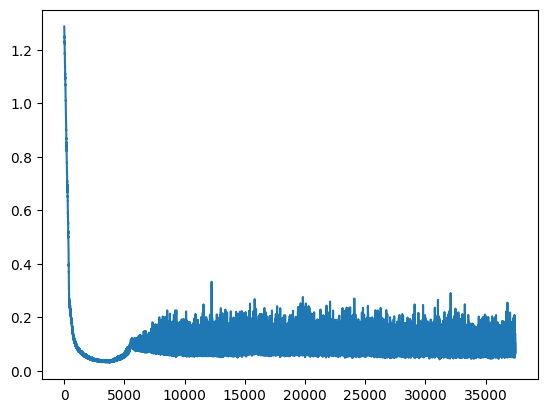

In [27]:
plt.plot(lossi)
#plt.yscale('log')

## Test Inference

In [28]:
val_dir = tok_dir / 'val'
pathway_names_path = data_dir / 'pathway_names.json'
gene_names_path = data_dir / 'gene_names.json'
pathway_names_path, gene_names_path, metadata_path, val_dir

(PosixPath('/Users/djemec/data/jepa/pathway_names.json'),
 PosixPath('/Users/djemec/data/jepa/gene_names.json'),
 PosixPath('/Users/djemec/data/jepa/perturbation_map.json'),
 PosixPath('/Users/djemec/data/jepa/tokenized/val'))

In [29]:
# 1. Load Map (ID -> Name)
with open(metadata_path, "r") as f:
    pert_map = json.load(f)
id_to_pert = {v: k for k, v in pert_map.items()}

with open(pathway_names_path, "r") as f:
    pathway_names = json.load(f) # List of 1024 names

with open(data_dir / 'gene_names.json', "r") as f:
    gene_names = json.load(f)

In [30]:
model.eval()

BioJepa(
  (student): CellStateEncoder(
    (total_count_proj): Linear(in_features=1, out_features=8, bias=True)
    (blocks): ModuleList(
      (0-5): 6 x CellStateBlock(
        (ln_1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attn): BioMultiHeadAttention(
          (q_proj): Linear(in_features=8, out_features=8, bias=True)
          (k_proj): Linear(in_features=8, out_features=8, bias=True)
          (v_proj): Linear(in_features=8, out_features=8, bias=True)
          (c_proj): Linear(in_features=8, out_features=8, bias=True)
        )
        (ln_2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=8, out_features=32, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=32, out_features=8, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  )
  (teacher): CellStateEncoder(
    (total_count_proj): Linear(in_features=

**Get random data sample**

In [31]:
def get_random_test_pair(shard_dir):
    '''Grab a single real pair from a random shard with Context'''
    files = sorted(shard_dir.glob('*.npz'))
        
    file_path = files[np.random.randint(len(files))]
    
    with np.load(file_path) as data:
        idx = np.random.randint(data['action_ids'].shape[0])
        
        # Extract Items (Now 5 items instead of 3)
        c_raw = data['control'][idx]         # [2000]
        ct_raw = data['control_total'][idx]  # Scalar
        case_raw = data['case'][idx]         # [2000]
        caset_raw = data['case_total'][idx]  # Scalar
        act_id = data['action_ids'][idx]     # Scalar
        
    # Convert to Tensor & Add Batch Dim [1, ...]
    xc = torch.tensor(c_raw).float().unsqueeze(0).to(DEVICE)
    xct = torch.tensor(ct_raw).float().unsqueeze(0).to(DEVICE)
    xt = torch.tensor(case_raw).float().unsqueeze(0).to(DEVICE)
    xtt = torch.tensor(caset_raw).float().unsqueeze(0).to(DEVICE)
    aid = torch.tensor([act_id]).long().to(DEVICE)
    
    return xc, xct, xt, xtt, aid

In [32]:
xc, xct, xt, xtt, aid = get_random_test_pair(val_dir)
pert_name = id_to_pert[aid.item()]
pert_name

'PDCD6'

In [33]:
with torch.no_grad():
    # Teacher sees the FUTURE (Real Treated Case)
    # Output: [1, 1024, 384]
    z_case = model.teacher(xt, xtt)       
    
    # Student sees the PAST (Control)
    # Output: [1, 1024, 384]
    z_context = model.student(xc, xct)
    
    # Control Baseline (Where we started in Teacher Space)
    # We run control through teacher to get the "Anchor"
    z_control = model.teacher(xc, xct) 

    # Predictor tries to guess Real from Context + Action
    z_predicted = model.predictor(z_context, aid)

**Analysis**

In [34]:
# Calculate Latent Movement
delta_latent = (z_predicted - z_control).squeeze(0) # [1024, 384]
delta_latent

tensor([[-0.0266,  0.0209,  0.0304,  ...,  0.0006,  0.0426,  0.0373],
        [-0.2126, -0.1474, -0.0014,  ...,  0.1809,  0.1622,  0.0549],
        [-0.0712,  0.0150,  0.0133,  ..., -0.0307,  0.0679,  0.0390],
        ...,
        [ 0.0206,  0.0348, -0.0349,  ..., -0.0149, -0.0127,  0.0063],
        [-0.0458,  0.0157,  0.0122,  ...,  0.0154,  0.0343,  0.0351],
        [-0.0614,  0.0211, -0.0121,  ..., -0.0448,  0.1328, -0.0076]])

In [35]:
# --- 3. Project "Pathway Energy" back to Genes ---
# We want to score every gene based on how much its parent pathways moved.
# Logic: Gene_Score = Sum(Mask_gp * Magnitude(Pathway_p))
# If a gene is in 5 pathways that all moved violently, that gene is highly implicated.
pathway_magnitudes = delta_latent.norm(dim=1) 
pathway_magnitudes

tensor([0.1021, 0.3734, 0.1344,  ..., 0.0654, 0.0864, 0.1801])

In [40]:
# 1. Access the Learnable Weights
# Shape in model: [1024 Pathways, 2000 Genes]
# We use .detach() because we are in eval mode and don't want gradients
weights = model.student.pathway_weights.detach()

# 2. Transpose back to [Genes, Pathways] for the projection
# We use .abs() because a strong negative weight (-5.0) implies 
# just as much biological "impact" as a strong positive one.
routing_matrix = weights.T.abs() # Shape: [2000, 1024]
routing_matrix

tensor([[0.0204, 0.0349, 0.0371,  ..., 0.0164, 0.0326, 0.0349],
        [0.0144, 0.0180, 0.0267,  ..., 0.0388, 0.0056, 0.0177],
        [0.0027, 0.0151, 0.0112,  ..., 0.0330, 0.0021, 0.0070],
        ...,
        [0.0345, 0.0216, 0.0287,  ..., 0.0195, 0.0310, 0.0203],
        [0.0312, 0.0205, 0.0297,  ..., 0.0042, 0.0265, 0.0338],
        [0.0169, 0.0285, 0.0179,  ..., 0.0076, 0.0427, 0.0185]])

In [41]:
# Project: [ Genes, 1024 Pathways] @ [1024 Magnitudes] -> [ Gene Scores]
# This tells us the "Implied Impact" on each gene
gene_impact_scores = torch.mv(routing_matrix, pathway_magnitudes)

In [46]:
# --- 4. Get Top Predicted Genes ---
top_k = 50
pred_values, pred_indices = torch.topk(gene_impact_scores, top_k)

In [47]:
print(f'Based on the pathway changes, the model predicts these genes are most affected:')
for val, idx in zip(pred_values, pred_indices):
    g_name = gene_names[idx.item()]
    print(f"  • {g_name:<10} (Score: {val.item():.4f})")

Based on the pathway changes, the model predicts these genes are most affected:
  • CASP3      (Score: 47.3649)
  • VEGFA      (Score: 44.7523)
  • AURKB      (Score: 38.2742)
  • MYC        (Score: 37.7240)
  • SLC7A1     (Score: 34.5717)
  • JUN        (Score: 33.5355)
  • NR3C1      (Score: 29.9030)
  • CYCS       (Score: 28.7485)
  • NFE2L2     (Score: 28.5994)
  • NFKB1      (Score: 27.9238)
  • MCL1       (Score: 27.8780)
  • EGR1       (Score: 26.1463)
  • NFKBIA     (Score: 26.0874)
  • ICAM1      (Score: 25.6151)
  • MAPK1      (Score: 24.6984)
  • HSPA1A     (Score: 24.5790)
  • BCL2L1     (Score: 24.5639)
  • STAT3      (Score: 24.4622)
  • SOD1       (Score: 23.6290)
  • DDIT3      (Score: 23.5433)
  • GADD45A    (Score: 22.9992)
  • HSPA5      (Score: 22.7473)
  • CDT1       (Score: 22.6832)
  • LDHA       (Score: 22.3313)
  • MTR        (Score: 22.3165)
  • PCNA       (Score: 21.8439)
  • PMAIP1     (Score: 21.4037)
  • CASP8      (Score: 21.2905)
  • HSPA1B     (Score: 2

In [48]:
# --- 5. REALITY CHECK (The most important part) ---
# Did these genes ACTUALLY change in the real data?
# Let's compare the Model's "Top Genes" vs the Reality's "Top Genes"
# Calculate Real Gene Change (Log Space)
# Shape: [1, 2000]
real_gene_delta = (xt - xc).abs().squeeze(0) 
# Get the Top 10 Genes that REALLY changed
real_values, real_indices = torch.topk(real_gene_delta, top_k)

In [49]:
print(f'Ground Truth')
for val, idx in zip(real_values, real_indices):
    g_name = gene_names[idx.item()]
    
    # Check if our model also listed this gene in its top 10
    match_icon = "✅" if idx in pred_indices else "❌"
    
    print(f"  {match_icon} {g_name:<10} (Delta: {val.item():.4f})")

Ground Truth
  ❌ CLTA       (Delta: 1.8917)
  ✅ MAPK1      (Delta: 1.8113)
  ❌ RANBP2     (Delta: 1.7240)
  ❌ RRM2       (Delta: 1.6282)
  ❌ STMN1      (Delta: 1.5836)
  ❌ EIF4A2     (Delta: 1.5223)
  ❌ HIST1H1B   (Delta: 1.5223)
  ❌ RBBP6      (Delta: 1.4874)
  ❌ ZCRB1      (Delta: 1.4874)
  ❌ RO60       (Delta: 1.4874)
  ❌ LAPTM5     (Delta: 1.4874)
  ❌ TCP1       (Delta: 1.4400)
  ❌ CORO1C     (Delta: 1.4039)
  ✅ HIST1H1E   (Delta: 1.4039)
  ❌ NAA10      (Delta: 1.4039)
  ❌ HIST1H2AC  (Delta: 1.4039)
  ❌ ABCE1      (Delta: 1.4039)
  ❌ ATF4       (Delta: 1.4039)
  ❌ SPCS3      (Delta: 1.3492)
  ❌ UROD       (Delta: 1.3492)
  ❌ FBXL20     (Delta: 1.3492)
  ❌ IFNGR2     (Delta: 1.3492)
  ❌ ACAT2      (Delta: 1.2802)
  ❌ MRPL12     (Delta: 1.2723)
  ❌ AC016074.2 (Delta: 1.2695)
  ❌ USP15      (Delta: 1.2695)
  ❌ KIF20B     (Delta: 1.2695)
  ❌ DDX3X      (Delta: 1.2695)
  ❌ HIC2       (Delta: 1.2695)
  ❌ PCM1       (Delta: 1.2695)
  ❌ UBR4       (Delta: 1.2695)
  ❌ ZNF621     (Delta: 1.2

In [50]:
# --- 6. Precision@10 Metric ---
# How many of the Top 10 real genes were in the Top 10 predicted genes?
# (Set intersection)
set_pred = set(pred_indices.tolist())
set_real = set(real_indices.tolist())
overlap = len(set_pred.intersection(set_real))

print(f"\n[Precision @ 10]")
print(f"The model correctly identified {overlap}/10 of the top driver genes.")


[Precision @ 10]
The model correctly identified 3/10 of the top driver genes.
